<a href="https://colab.research.google.com/github/isakdiaz/PlantNet_MobileNetV2/blob/main/PlantNet_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Tensorflow and other things

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pprint
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

## Check you are running on a TPU Or...


In [3]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('✅ Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  print("❌ No TPU Found! At the top click Runtime -> Change Runtime Type -> Hadrware Accelerator -> TPU")

❌ No TPU Found! At the top click Runtime -> Change Runtime Type -> Hadrware Accelerator -> TPU


##  Check if you are running on a GPU

In [4]:
# Check if running on GPU
import tensorflow as tf
gpu_location = tf.test.gpu_device_name()
if gpu_location:
  print("✅ GPU found at " + gpu_location)
else:
  print("❌ No GPU Found!. At the top click Runtime -> Change Runtime Type -> Hadrware Accelerator -> GPU")

✅ GPU found at /device:GPU:0


## Version Notice
This code assumes you are using tensorflow 2.0 or later and python 3.6 or later

In [5]:
print("Tensorflow version is " + tf.__version__)
print("Numpy version is " + np.__version__)

Tensorflow version is 2.6.0
Numpy version is 1.19.5


In [6]:
!pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-v8ywsj6g
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-v8ywsj6g
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0f52511c19860e9947261aef83d6b66b6f7a0a3a4_-py3-none-any.whl size=154537 sha256=dd901c2490f7b69e1fe6587c57d6ff4e6a242d42d4ff2b956b73d2f1e5905ead
  Stored in directory: /tmp/pip-ephem-wheel-cache-i0tszuua/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [7]:
import tensorflow_docs as tdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
# Place the plantnet zipped file in a folder called plantnet on your Google Drive directory
# Unzips files from google drive to google colab
!unzip /content/drive/MyDrive/plantnet/plantnet_300K.zip

In [10]:
# Check file unzipped properly and is 31GB
!du -hs plantnet_300K/

31G	plantnet_300K/


In [11]:
ls plantnet_300K/

images_test/   images_val/                 plantnet300K_species_names.json
images_train/  plantnet300K_metadata.json  README


In [14]:
 # Check species classes vs folder names
FOLDER_TO_CLASS_JSON = "plantnet_300K/plantnet300K_species_names.json"

with open(FOLDER_TO_CLASS_JSON) as f:
  class_dict = json.load(f)
class_list = list(class_dict.values())

print(str(len(class_list)) + " classes found in dataset")
#cat plantnet_300K/plantnet300K_species_names.json

1081 classes found in dataset


# Create Datasets for training process
## Pick a Method






In [47]:
SEED = 123
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_folder = "plantnet_300K/images_train/"
validation_folder = "plantnet_300K/images_val/"
test_folder = "plantnet_300K/images_test/"

# Method 1
Smart Resize already implemented, but is missing Data Augmentation


In [48]:
train_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "plantnet_300K/images_train/", labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, seed=SEED,
    interpolation='bilinear', follow_links=False, smart_resize=True
)
val_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "plantnet_300K/images_val/", labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE,
     shuffle=True, seed=SEED,
    interpolation='bilinear', follow_links=False, smart_resize=True
)

test_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "plantnet_300K/images_test/", labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE,
     shuffle=True, seed=SEED,
    interpolation='bilinear', follow_links=False, smart_resize=True
)

@tf.function
def process_dataset(image, label):
  # image = tf.image.resize(image, (224, 224))
  # image = preprocess_input(image)
  image = image/127.0 - 1 #normalize around -1 to +1
  return(image, label)

train_dataset = train_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)
val_dataset = val_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)
test_dataset = test_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)

Found 243916 files belonging to 1081 classes.
Found 31118 files belonging to 1081 classes.
Found 31112 files belonging to 1081 classes.


Plot Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


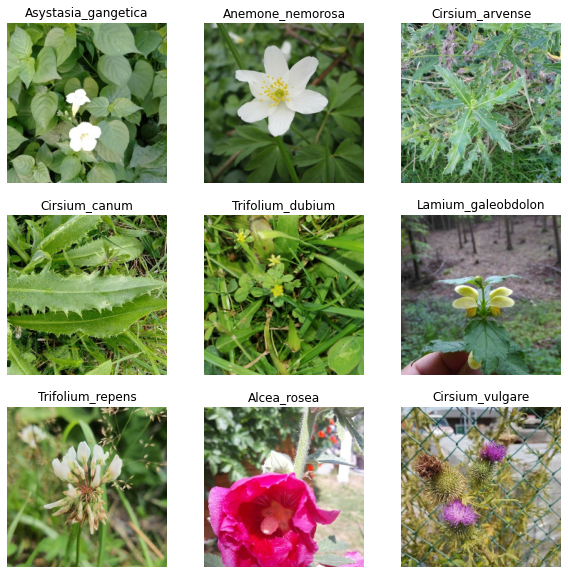

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = (images[i].numpy() + 1)/ 2.0
        plt.imshow(image)
        plt.title(class_list[np.argmax(labels[i])])
        plt.axis("off")

# Method 2


Data Augmentation included but is missing Smart Resize




In [80]:
@tf.function
def center_crop(img): # TODO DOESNT WORK ATM

  # print(img)
  # print(type(img))
  # target_width = IMAGE_SIZE[1]
  # target_height = IMAGE_SIZE[0]
  # imgtest=img
  # width, height = img.size

  # left_corner = int(round(width/2)) - int(round(target_width/2))
  # top_corner = int(round(height/2)) - int(round(target_height/2))

  # img = img.crop((left_corner, top_corner, left_corner + target_width, top_corner + target_height))
  # IMAGE_SIZE=(224,224)
  img = tf.keras.preprocessing.image.smart_resize(img, IMAGE_SIZE, interpolation='bilinear')

  return img

# def process_dataset(image, label):
#   # image = tf.image.resize(image, (224, 224))
#   # image = preprocess_input(image)
#   image = image/127.0 - 1 #normalize around -1 to +1

#   return(image, label)

# By default flow_from_directory shuffles data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.5,1.0),
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="reflect",
        # preprocessing_function=center_crop
        )
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

train_dataset = train_generator
val_dataset = validation_generator

Found 243916 images belonging to 1081 classes.
Found 31118 images belonging to 1081 classes.


Plot Images


Image Sizes: (256, 224, 224, 3)


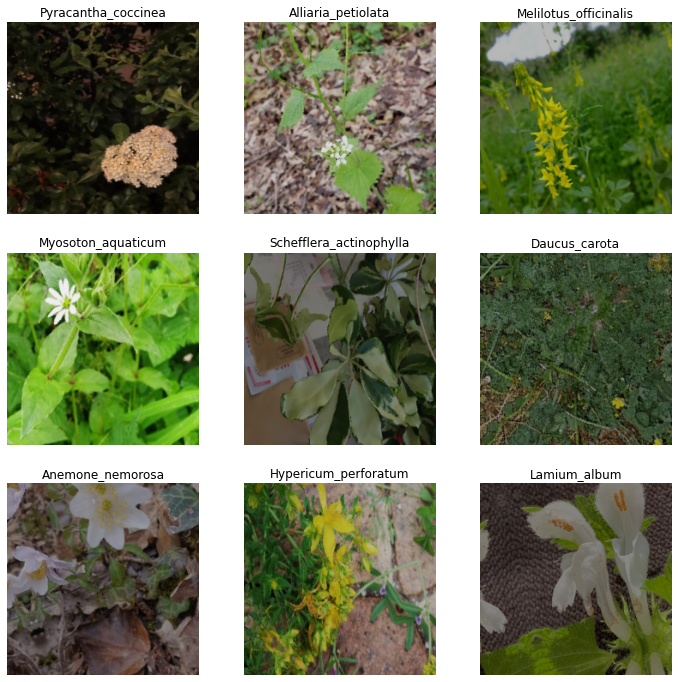

In [81]:
import matplotlib.pyplot as plt

x,y = train_dataset.next()
print("Image Sizes: " + str(x.shape))

plt.figure(figsize=(12, 12))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = x[i] 
    plt.imshow(image)
    plt.title(class_list[np.argmax(y[i])])
    plt.axis("off")

## Create Model Base from MobileNetV2 without top layers


In [85]:
# Mobilenet was originally trained with -1 to +1 values, Normalizer sets images within this range so pretrained weights work properly

base_model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling=None,
    classifier_activation="softmax",
)

# Combine input layer with base model
# full_model = Model(inputs=[inputs], outputs=[base_model.output])

## Add Top layer to base model

In [86]:
# inputs = tf.keras.Input(shape=(224,224,3))
# x = normalizer(inputs)
# x = tf.keras.backend.function([x, tf.keras.backend.learning_phase()], base_model.input) 
x = base_model.output
# Let's add final trainable layers to learn our specific data
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1081, activation="softmax")(x)

## Freeze the model middle layers

In [87]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers at first.
base_model.trainable = False


## Finish creating complete model



In [88]:
# model = Model(inputs = inputs, outputs = predictions)
model = Model(inputs = base_model.input, outputs = predictions)

In [89]:
OPTIMIZER = "adam"
LEARNING_RATE = 0.1

if OPTIMIZER == "adam":
  opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
elif OPTIMIZER == "rmsprop":
  opt = "rmsprop"

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics= ["accuracy", 'top_k_categorical_accuracy'])

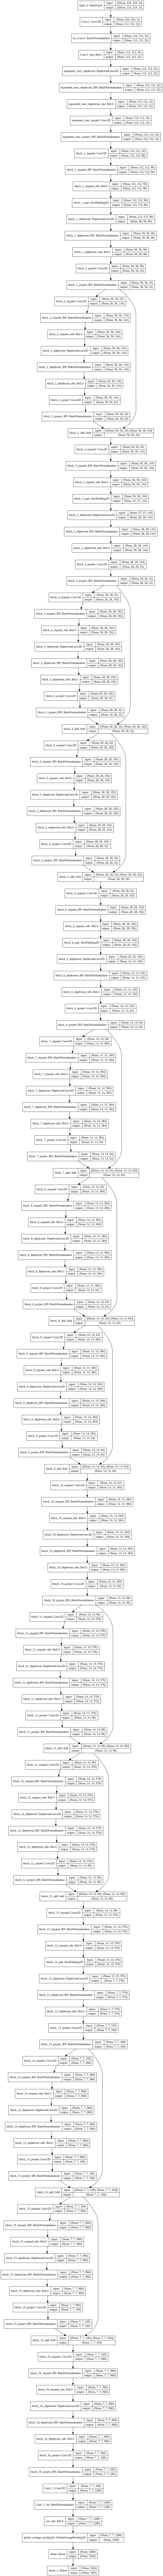

In [90]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [95]:
# Callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime 

current_time = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
current_date = datetime.now().strftime('%Y-%m-%d')

gdrive_dir = "/content/drive/MyDrive/saved_models/"
filepath = "/content/drive/MyDrive/saved_models/plantNet_256_adam_0.1_2021-08-20.h5"

# Try loading model at filepath to continue training
# If no file exists then it creates a new one
try:
  model = keras.models.load_model(filepath)
  print("Continuing training from checkpoint")
except:
  print("No keras model found at {}, will start training from scratch.".format(filepath))
  filepath = "{0}plantNet_{1}_{2}_{3}_{4}.h5".format(gdrive_dir, BATCH_SIZE, OPTIMIZER, LEARNING_RATE, current_date)
  
  print("New model filename is {}".format(filepath))


# Save model only when validation accuracy increases
# checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_best_only=True, mode="max")
checkpoint = ModelCheckpoint(filepath, save_best_only=False, save_weights_only=False)

# Tensorboard callback
logdir = gdrive_dir + "logs/" + current_time
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_images=True, embeddings_freq=1)

# Stop training model if validation loss does not improve for 3 epochs
earlyStopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

callbacks_list = [checkpoint, earlyStopping, tensorboard_callback]

No keras model found at /content/drive/MyDrive/saved_models/plantNet_256_adam_0.1_2021-08-20.h5, will start training from scratch.
New model filename is /content/drive/MyDrive/saved_models/plantNet_256_adam_0.1_2021-08-20.h5


## Train Model

In [ ]:
epochs = 5
steps_per_epoch = None
# val_dataset = None
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=callbacks_list, steps_per_epoch=steps_per_epoch)



/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
 24/953 [..............................] - ETA: 1:10:16 - loss: 94.8057 - accuracy: 0.0223 - top_k_categorical_accuracy: 0.1354